In [149]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

In [150]:
# загрузка датасета
data = pd.read_csv('train_new2.csv', delimiter=';', encoding="cp1251")

In [151]:
data.head

<bound method NDFrame.head of           p1      p2      s2       s3       s4      s7       s8       s9  \
0    -0.0007 -0.0004  641.82  1589.70  1400.60  554.36  2388.06  9046.19   
1     0.0019 -0.0003  642.15  1591.82  1403.14  553.75  2388.04  9044.07   
2    -0.0043  0.0003  642.35  1587.99  1404.20  554.26  2388.08  9052.94   
3     0.0007  0.0000  642.35  1582.79  1401.87  554.45  2388.11  9049.48   
4    -0.0019 -0.0002  642.37  1582.85  1406.22  554.00  2388.06  9055.15   
...      ...     ...     ...      ...      ...     ...      ...      ...   
9904  0.0037  0.0004  643.77  1604.93  1423.51  551.41  2388.18  9128.75   
9905  0.0019 -0.0004  643.33  1605.31  1434.87  551.25  2388.17  9134.70   
9906  0.0020 -0.0002  643.32  1602.26  1430.01  551.40  2388.19  9129.59   
9907 -0.0026 -0.0001  643.73  1599.94  1432.87  551.18  2388.19  9132.97   
9908  0.0039  0.0001  643.83  1608.20  1433.88  552.06  2388.20  9128.91   

        s11     s12      s13      s14  s17    s20      s2

In [152]:
#data = data.drop(['unit', 'time', 'p3', 's1', 's5', 's6', 's10', 's15', 's16', 's18', 's19'], axis=1)
#data.dropna(inplace=True)

In [153]:
#подготовка данных
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(['time_before_failure'], axis=1).values)
y = data['time_before_failure'].values #доп столбец "кол-во циклов до отказов"

In [154]:
# разбиение на выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [155]:
# архитектура модели
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [156]:
# функция потерь и оптимизатор
model.compile(loss=MeanSquaredError(), optimizer=Adam())

In [157]:
# метрики
metrics = [RootMeanSquaredError(name='rmse'), MeanAbsoluteError(name='mae')]

In [158]:
# обучение модели
from keras.callbacks import EarlyStopping

stopper = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=1000, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[stopper], verbose=0)

In [159]:
# оценка модели на тестовых данных
score = model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 13228.0420


In [160]:
# вывод результатов метрик
print('Test RMSE:', np.sqrt(score))
print('Test MAE:', score) 

Test RMSE: 115.01322529251799
Test MAE: 13228.0419921875


In [161]:
from tensorflow.keras.callbacks import History

# определяем историю обучения
history1 = History()

In [162]:
# обучаем модель на тренировочных данных
model.fit(X_train, y_train, epochs=1000, batch_size=32,
                    validation_data=(X_valid, y_valid), callbacks=[history1], verbose=0)

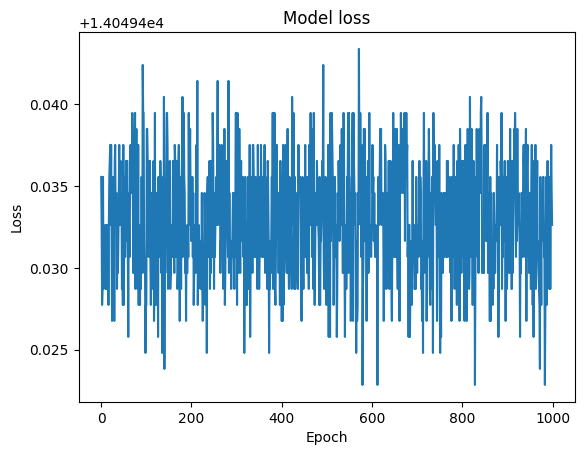

In [163]:
# графики обучения
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [166]:
# сохраняем модель
model.save('CNN_model_NEW2.h5')

In [167]:
# загрузка модели
from tensorflow.keras.models import load_model

loaded_model = load_model('CNN_model_NEW2.h5')